# v2

- Re-grouped functions for better OOP structure
- Test protein .fasta sequences from reviewed UNIPROT entries

# Imports

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, stats


from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import sys
import multiprocessing as mp

from Bio import SeqIO, SeqUtils
import math
import time

In [6]:
sys.path.append("./mean_field_electrostatics/v2/")
import base_classes
import morbidelli as m
import hubbuch as h
import hsu
import misc_functions as misc

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

# FASTA sequences

In [7]:
# records = {}
# i = 0
# for r in SeqIO.parse("/home/chase/my_work/misc/databases/uniprot_reviewed.fasta", "fasta"):
#     if 'X' not in r.seq and 'Z' not in r.seq and 'B' not in r.seq and 'J' not in r.seq: # remove records with sequence ambiguity
#         records[i] = r
#         i += 1

# Morbidelli model

## Development example

In [10]:
def m_residual(ion_str, kprime_target, dpr, seq, pH, surf_area, porosity, surf_dens):
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    res = m.resin(sol, 'sulfonate', surf_dens=surf_dens, dpr=dpr)
    pro = m.protein(sol, seq=seq, dpr=dpr)    
    kprime   = m.get_kprime(surf_area, porosity, pro, res)
    return abs(np.log10(kprime) - np.log10(kprime_target))

def get_is_for_kprime(args):
    fit = optimize.minimize_scalar(m_residual, args=args, bounds=[1.0e-3, 1], method='Bounded')
    assert fit.success
    return fit.x

In [11]:
seq       = records[0].seq
dpr       = 2.0e-10 # minimum resting distance, m
surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
porosity  = 0.7     # accessible particle porosity
pH        = 7.0
surf_dens = 3.413e-6

k_targets = [100, 0.1]
is_vals =[]
for k_target in k_targets:
    args = (k_target, dpr, seq, pH, surf_area, porosity, surf_dens)
    is_val = get_is_for_kprime(args)
    is_vals.append(is_val)

nu, phi_alpha = misc.get_nu_alpha(is_vals, k_targets)

In [12]:
is_vals_demo     = np.logspace(np.log10(0.05), np.log10(0.5), 25)
kprime_vals_demo = []

for ion_str in is_vals_demo:
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    res = m.resin(sol, 'sulfonate', surf_dens=3.413e-6, dpr=dpr)
    pro = m.protein(sol, seq, dpr=dpr)
    kprime = m.get_kprime(surf_area, porosity, pro, res)
    kprime_vals_demo.append(kprime)

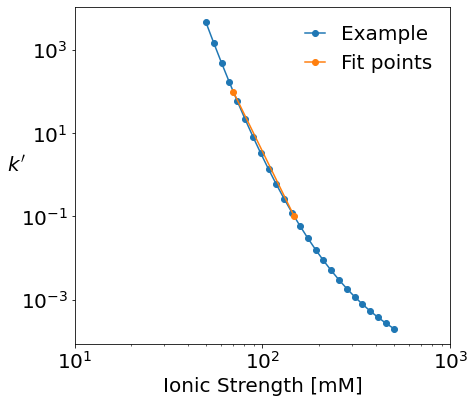

In [14]:
fig, ax = my_plot.instantiate_fig()
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel('$k\'$', rotation=0)
ax.set_xlim(10, 1000)

ax.loglog(is_vals_demo*1e3, kprime_vals_demo, 'o-', label='Example')
ax.loglog(np.array(is_vals)*1e3, k_targets, 'o-', label='Fit points')
my_plot.set_layout(fig, ax, legend=True)
# fig.savefig(f'./images/mean_field_electrostatics/morbidelli/fit_region.png', dpi=300)

## Varying parameters

In [21]:
def m_corr_residual(log_ion_str, seq, surf_dens, pH, dpr, surf_area, porosity, kprime_target, negative_sign=True):
    ion_str = 10.0**log_ion_str
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    pro = m.protein(sol, seq=seq, dpr=dpr, negative_sign=negative_sign)    
    if pro.net_charge > 0:
        ligand = 'sulfonate'
    elif pro.net_charge < 0:
        ligand = 'quat_amine'
    else:
        assert False 
    res = m.resin(sol, ligand, surf_dens=surf_dens, dpr=dpr)
    
    kprime   = m.get_kprime(surf_area, porosity, pro, res)
    residual = np.log10(kprime) - np.log10(kprime_target)
    return residual

def corr_get_is_for_kprime(args, corr_residual_function):
    fit = optimize.least_squares(corr_residual_function, x0=[0], args=args, bounds=(-10, 10), ftol=1e-12, gtol=3e-16, xtol=3e-16)
    x0 = -2
    while abs(fit.fun[0]) > 1e-6:
        x0 -= 1
        fit = optimize.least_squares(corr_residual_function, x0=[x0], args=args, bounds=(-10, 10), ftol=1e-12, gtol=3e-16, xtol=3e-16)
        if x0 < -8:
            break
    assert fit.success
    assert fit.fun[0] < 1e-6 
    return 10.0**fit.x[0]

def run(args):
    p_id, seq, surf_dens, pH, negative_sign = args    
    dpr       = 2.0e-10 # minimum resting distance, m
    surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
    porosity  = 0.7     # accessible particle porosity

    sol = base_classes.solution(pH=7.0, ion_str=0.1)
    pro = m.protein(sol, seq=seq, dpr=dpr) 
    
    k_targets = [100, 0.1]
    is_vals =[]
    
    try:
        for k in k_targets:
            args = (seq, surf_dens, pH, dpr, surf_area, porosity, k, negative_sign)
            is_val = corr_get_is_for_kprime(args=args, corr_residual_function=m_corr_residual)
            is_vals.append(is_val)

        nu, phi_alpha = misc.get_nu_alpha(is_vals, k_targets)
        results = [p_id, pro.net_charge, nu, phi_alpha]
        return results
    except:
        pass

### Theoretically correct formulation

In [22]:
import warnings
warnings.simplefilter('ignore')

n = 100
for j in range(41, n):
    t0 = time.time()
    args_list = []
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        r = records[i]
        args_list.append((r.id, r.seq, 3.0e-6, 7.0, True))

    pool    = mp.Pool(processes = mp.cpu_count())
    results = pool.map(run, args_list)
    pool.close()
    pool.join()

    results = [k for k in results if k is not None]
    df_model = pd.DataFrame(results, columns=['id', 'charge', 'nu', 'phi_alpha'])
    df_model.to_csv(f'./mean_field_electrostatics/uniprot_morbidelli/{j}.csv', index=False)
    
    t = (time.time() - t0)/60
    print(f'{j}, {t:.2f} min')

41, 1.10 min
42, 1.10 min
43, 1.12 min
44, 1.10 min
45, 1.14 min
46, 1.20 min
47, 1.15 min
48, 1.20 min
49, 1.16 min
50, 1.16 min
51, 1.16 min
52, 1.17 min
53, 1.24 min
54, 1.20 min
55, 1.21 min
56, 1.21 min
57, 1.20 min
58, 1.15 min
59, 1.22 min
60, 1.23 min
61, 1.16 min
62, 1.20 min
63, 1.15 min
64, 1.11 min
65, 1.08 min
66, 1.08 min
67, 1.09 min
68, 1.10 min
69, 1.19 min
70, 1.19 min
71, 1.19 min
72, 1.10 min
73, 1.09 min
74, 1.11 min
75, 1.15 min
76, 1.19 min
77, 1.21 min
78, 1.19 min
79, 1.17 min
80, 1.21 min
81, 1.25 min
82, 1.33 min
83, 1.21 min
84, 1.21 min
85, 1.17 min
86, 1.19 min
87, 1.19 min
88, 1.18 min
89, 1.16 min
90, 1.21 min
91, 1.22 min
92, 1.18 min
93, 1.12 min
94, 1.13 min
95, 1.13 min
96, 1.14 min
97, 1.16 min
98, 1.15 min
99, 1.18 min


### Formulation without the negative sign

In [23]:
import warnings
warnings.simplefilter('ignore')

n = 100
for j in range(20, n):
    t0 = time.time()
    args_list = []
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        r = records[i]
        args_list.append((r.id, r.seq, 3.0e-6, 7.0, False))

    pool    = mp.Pool(processes = mp.cpu_count())
    results = pool.map(run, args_list)
    pool.close()
    pool.join()

    results = [k for k in results if k is not None]
    df_model = pd.DataFrame(results, columns=['id', 'charge', 'nu', 'phi_alpha'])
    df_model.to_csv(f'./mean_field_electrostatics/uniprot_morbidelli_positive_sign/{j}.csv', index=False)
    
    t = (time.time() - t0)/60
    print(f'{j}, {t:.2f} min')

20, 1.15 min
21, 1.10 min
22, 1.11 min
23, 1.16 min
24, 1.43 min
25, 1.14 min
26, 1.15 min
27, 1.15 min
28, 1.20 min
29, 1.11 min
30, 1.11 min
31, 1.09 min
32, 1.09 min
33, 1.16 min
34, 1.10 min
35, 1.11 min
36, 1.21 min
37, 1.11 min
38, 1.06 min
39, 1.22 min
40, 1.13 min
41, 1.10 min
42, 1.15 min
43, 1.16 min
44, 1.14 min
45, 1.09 min
46, 1.19 min
47, 1.15 min
48, 1.16 min
49, 1.19 min
50, 1.23 min
51, 1.17 min
52, 1.22 min
53, 1.07 min
54, 1.12 min
55, 1.14 min
56, 1.09 min
57, 1.17 min
58, 1.09 min
59, 1.20 min
60, 1.13 min
61, 1.29 min
62, 1.08 min
63, 1.08 min
64, 1.01 min
65, 0.96 min
66, 0.96 min
67, 0.99 min
68, 0.98 min
69, 1.17 min
70, 1.10 min
71, 1.14 min
72, 0.98 min
73, 1.01 min
74, 0.99 min
75, 1.17 min
76, 1.12 min
77, 1.11 min
78, 1.16 min
79, 1.09 min
80, 1.15 min
81, 1.06 min
82, 1.02 min
83, 1.14 min
84, 1.15 min
85, 1.13 min
86, 1.12 min
87, 1.14 min
88, 1.16 min
89, 1.15 min
90, 1.13 min
91, 1.15 min
92, 1.10 min
93, 1.06 min
94, 1.07 min
95, 1.09 min
96, 1.09 min

# Hubbuch model
## Development example

In [24]:
def h_residual(ion_str, kprime_target, seq, pH, surf_area, porosity, surf_dens):
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    res = h.resin(sol, 'sulfonate', surf_dens=3.0e-6)
    pro = h.protein(sol, seq=seq)  
    kprime = h.get_kprime(surf_area, porosity, pro, res)
    return abs(np.log10(kprime) - np.log10(kprime_target))

def get_is_for_kprime(args):
    fit = optimize.minimize_scalar(h_residual, args=args, bounds=[1.0e-3, 1], method='Bounded')
    assert fit.success
    return fit.x

In [25]:
seq       = records[0].seq
surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
porosity  = 0.7     # accessible particle porosity
pH        = 7.0
surf_dens = 3.413e-6

k_targets = [100, 0.1]
is_vals =[]
for k_target in k_targets:
    args = (k_target, seq, pH, surf_area, porosity, surf_dens)
    is_val = get_is_for_kprime(args)
    is_vals.append(is_val)

nu, phi_alpha = misc.get_nu_alpha(is_vals, k_targets)

In [26]:
is_vals_demo     = np.logspace(np.log10(0.05), np.log10(0.5), 25)
kprime_vals_demo = []

for ion_str in is_vals_demo:
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    res = h.resin(sol, 'sulfonate', surf_dens=3.0e-6)
    pro = h.protein(sol, seq=seq)  
    kprime = h.get_kprime(surf_area, porosity, pro, res)
    kprime_vals_demo.append(kprime)

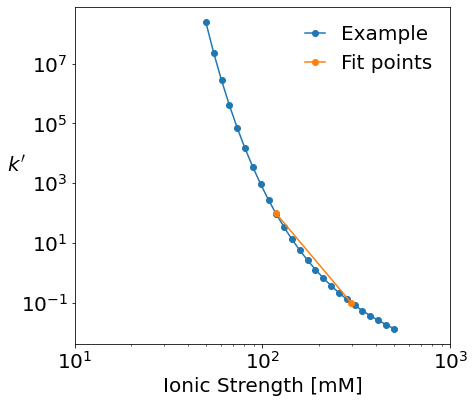

In [27]:
fig, ax = my_plot.instantiate_fig()
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel('$k\'$', rotation=0)
ax.set_xlim(10, 1000)

ax.loglog(is_vals_demo*1e3, kprime_vals_demo, 'o-', label='Example')
ax.loglog(np.array(is_vals)*1e3, k_targets, 'o-', label='Fit points')
my_plot.set_layout(fig, ax, legend=True)

## Morbidelli - Hubbuch comparison

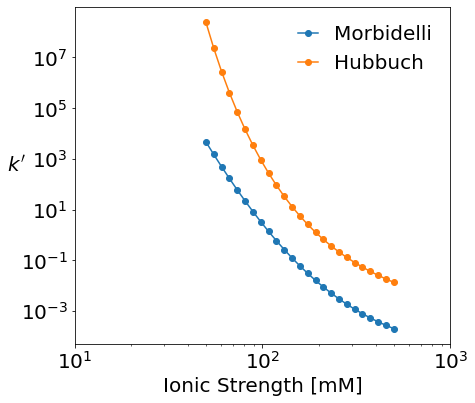

In [28]:
m_kprime = []
for ion_str in is_vals_demo:
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    res = m.resin(sol, 'sulfonate', surf_dens=3.413e-6, dpr=2.0e-10)
    pro = m.protein(sol, seq, dpr=dpr)
    m_kprime.append( m.get_kprime(surf_area, porosity, pro, res) )

h_kprime = []
for ion_str in is_vals_demo:
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    res = h.resin(sol, 'sulfonate', surf_dens=3.0e-6)
    pro = h.protein(sol, seq=seq)  
    h_kprime.append( h.get_kprime(surf_area, porosity, pro, res) )

    
fig, ax = my_plot.instantiate_fig()
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel('$k\'$', rotation=0)
ax.set_xlim(10, 1000)

ax.loglog(is_vals_demo*1e3, m_kprime, 'o-', label='Morbidelli')
ax.loglog(is_vals_demo*1e3, h_kprime, 'o-', label='Hubbuch')
my_plot.set_layout(fig, ax, legend=True)
# fig.savefig(f'./images/mean_field_electrostatics/Morbidelli_Hubbuch_comparison.png', dpi=300)

## Hubbuch - varying parameters

In [29]:
def get_ligand(sol, seq):
    pro = m.protein(sol, seq=seq, dpr=2.0e-10, negative_sign=True)    
    if pro.net_charge > 0:
        ligand = 'sulfonate'
    elif pro.net_charge < 0:
        ligand = 'quat_amine'
    else:
        assert False 
    return ligand

def h_residual(ion_str, kprime_target, seq, pH, surf_area, porosity, surf_dens):
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    ligand = get_ligand(sol, seq)
    res = h.resin(sol, ligand, surf_dens=surf_dens)
    pro = h.protein(sol, seq=seq)  
    kprime = h.get_kprime(surf_area, porosity, pro, res)
    return abs(np.log10(kprime) - np.log10(kprime_target))

def get_is_for_kprime(args):
    fit = optimize.minimize_scalar(h_residual, args=args, bounds=[1.0e-3, 3], method='Bounded')
    if fit.success:
        return fit.x
    else:
        return None

def h_run(args):
    p_id, seq, surf_dens, pH = args    
    surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
    porosity  = 0.7     # accessible particle porosity

    sol = base_classes.solution(pH=7.0, ion_str=0.1)
    pro = m.protein(sol, seq=seq, dpr=2.0e-10, negative_sign=True)      
    net_charge = pro.net_charge
    
    k_targets = [100, 0.1]
    is_vals = []
    
    try:
        for k in k_targets:
            args = (k, seq, pH, surf_area, porosity, surf_dens)
            is_val = get_is_for_kprime(args)
            is_vals.append(is_val)

        if None not in is_vals:
            nu, phi_alpha = misc.get_nu_alpha(is_vals, k_targets)
            results = [p_id, net_charge, nu, phi_alpha]
            return results
        else:
            return None
    except:
        pass

In [30]:
# import warnings
# warnings.simplefilter('ignore')

n = 100
for j in range(20, n):
    t0 = time.time()
    args_list = []
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        r = records[i]
        args_list.append((r.id, r.seq, 3.0e-6, 7.0))

    pool    = mp.Pool(processes = mp.cpu_count())
    results = pool.map(h_run, args_list)
    pool.close()
    pool.join()

    results = [k for k in results if k is not None]
    df_model = pd.DataFrame(results, columns=['id', 'charge', 'nu', 'phi_alpha'])
    df_model.to_csv(f'./mean_field_electrostatics/uniprot_hubbuch/{j}.csv', index=False)
    
    t = (time.time() - t0)/60
    print(f'{j}, {t:.2f} min')

20, 2.78 min
21, 2.78 min
22, 2.85 min
23, 2.85 min
24, 2.84 min
25, 2.81 min
26, 2.81 min
27, 2.86 min
28, 2.83 min
29, 2.77 min
30, 2.84 min
31, 2.82 min
32, 2.81 min
33, 2.77 min
34, 2.78 min
35, 2.84 min
36, 2.90 min
37, 2.81 min
38, 2.79 min
39, 2.83 min
40, 2.81 min
41, 2.81 min
42, 2.84 min
43, 2.83 min
44, 2.83 min
45, 2.80 min
46, 2.81 min
47, 2.83 min
48, 2.79 min
49, 2.89 min
50, 2.90 min
51, 2.81 min
52, 2.84 min
53, 2.79 min
54, 2.86 min
55, 2.77 min
56, 2.77 min
57, 2.85 min
58, 2.82 min
59, 2.80 min
60, 2.90 min
61, 2.91 min
62, 2.79 min
63, 2.76 min
64, 2.53 min
65, 2.46 min
66, 2.49 min
67, 2.51 min
68, 2.59 min
69, 2.81 min
70, 2.77 min
71, 2.73 min
72, 2.50 min
73, 2.46 min
74, 2.61 min
75, 2.80 min
76, 2.82 min
77, 2.79 min
78, 2.82 min
79, 2.78 min
80, 2.78 min
81, 2.78 min
82, 2.76 min
83, 2.80 min
84, 2.83 min
85, 2.78 min
86, 2.82 min
87, 2.86 min
88, 2.87 min
89, 2.86 min
90, 2.77 min
91, 2.81 min
92, 2.75 min
93, 2.79 min
94, 2.77 min
95, 2.77 min
96, 2.77 min

# Comparison with lit. SDM parameters

## Combining separate .csv files 

And looking at data

In [ ]:
directory = './mean_field_electrostatics/'
folders = [f for f in os.listdir(directory) if 'uniprot' in f]
folders.sort()

In [14]:
for folder in folders:
    files = os.listdir(directory + folder)
    files = [f for f in files if ('consolidated' not in f) and ('clean' not in f)]
    files.sort()
    
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(directory + folder + '/' + file)
        else:
            df_temp = pd.read_csv(directory + folder + '/' + file)
            df = pd.concat((df, df_temp))
    
    df.to_csv(directory + folder + '/consolidated.csv', index=False)

In [33]:
for folder in folders:
    df = pd.read_csv(directory + folder + '/consolidated.csv')
    df_temp = df[(abs(df.nu) != np.inf) & (abs(df.phi_alpha) != np.inf)]
    
    # Checks
    print(folder)
    print(len(set(df_temp.id)) - len(df_temp))
    df_bad_solution = df_temp[(df.nu < 0) | (df.phi_alpha < 0)]
    print(len(df_bad_solution))
    
    df_clean = df_temp[(df.nu >= 0) & (df.phi_alpha >= 0)]
    df_temp.to_csv(directory + folder + '/clean.csv', index=False)

uniprot_hubbuch
0
7
uniprot_morbidelli
0
0
uniprot_morbidelli_positive_sign
0
2


In [35]:
n = 100
for j in range(n):
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        pass
    
max_num = i
max_num

562880

In [36]:
for folder in folders:
    df = pd.read_csv(directory + folder + '/clean.csv')
    print(folder)
    print(f'{len(df)}, {len(df)/max_num*100:.2f}%')

uniprot_hubbuch
319456, 56.75%
uniprot_morbidelli
526993, 93.62%
uniprot_morbidelli_positive_sign
527245, 93.67%


## Comparison

In [8]:
def my_fit_function_ln_keq_2(tis, a, b):
    return np.log(a*tis**b)

def meta_correlation(a, c, d):
    return c*np.log(a) + d

def get_meta_residuals(x, a_vals, b_vals):
    c = x[0]
    d = x[1]
    return b_vals - (c*np.log(a_vals) + d)

def get_reg_intervals(x, y, alpha=0.05, line_extension=0.0):
    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment
    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(1.0-alpha/2.0, dof) # Students statistic of interval confidence

    residual = y - y_model
    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # mean squared error
    MSE = 1/n * np.sum( residual**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x)-line_extension, np.max(x)+line_extension, 1000)
    y_line = np.polyval([slope, intercept], x_line)

    # intervals
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    pred_err_var = (std_error**2.0) * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
    
    return x_line, y_line, ci, pi, pred_err_var

def get_pred_err_var(x, y, x_star):
    slope, intercept = np.polyfit(x, y, 1)  
    y_model = np.polyval([slope, intercept], x)  
    residual = y - y_model

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                       
    m = 2                            
    dof = n - m   
    
    pred_err_var = (np.sum(residual**2) / dof) * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))
    return pred_err_var
    
def plot_intervals(x, y, x_line, y_line, ci, pi):
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_xscale('log')
    
    color = 'blue'
    ax.plot(np.exp(x), y, 'o', color = 'royalblue')
    ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
#     ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse(x, y, x_line, y_line, ci, pi):
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$a$')
    ax.set_yscale('log')
    
    color = 'blue'
    ax.plot(x, np.exp(y), 'o', color = 'royalblue')
    ax.plot(x_line, np.exp(y_line), color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, np.exp(y_line + pi), np.exp(y_line - pi), color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, np.exp(y_line + ci), np.exp(y_line - ci), color = 'skyblue', label = '95% CI')
    ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse_ln(x, y, x_line, y_line, ci, pi):
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$ln(a)$')
    
    color = 'blue'
    ax.plot(x, y, 'o', color = 'royalblue')
    ax.plot(x_line, y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
    ax.legend(loc='lower left', fontsize=16)

    return fig, ax

In [9]:
# Load data
df_all_k = pd.read_csv('./lit_data/all_kprime.csv')
df_all_k.fillna(0.0, inplace=True)

df_2_fit_parms = pd.read_csv('./lit_data/two_params_all_data.csv')
resins = list(set(df_2_fit_parms.resin))
resins.sort()

df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)
data = np.zeros((len(df_2_fit_parms), 2))
data[:,0] = df_2_fit_parms.ln_a
data[:,1] = df_2_fit_parms.b

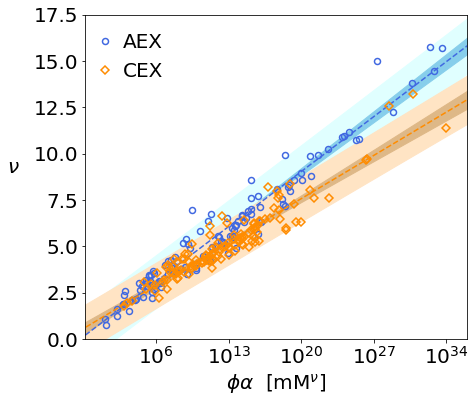

In [24]:
def plot_lit_data():
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
    ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

    ax.set_xscale('log')
    # Normal lim
    ax.set_xlim(np.exp(-2), np.exp(83))
    ax.set_ylim(0, 17.5)
    ## Larger lim
#     ax.set_xlim(np.exp(-20), 1.0e55)
#     ax.set_ylim(0, 30)

    iex_type_list = ['aex', 'cex']
    for iex_type in iex_type_list:
        df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

        data = np.zeros((len(df), 2))
        data[:,0] = df.ln_a
        data[:,1] = -1*df.b

        x = data[:,0]
        y = data[:,1]

        x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)

        if iex_type == 'aex':
            color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
            marker, fillstyle = 'o', 'full'
        elif iex_type == 'cex':
            color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
            marker, fillstyle = 'D', 'full'

        ax.plot(np.exp(x), y, marker=marker, fillstyle='none', markeredgewidth=1.5, linewidth=0, color=color_1, label=iex_type.upper())
        ax.plot(np.exp(x_line), y_line, color=color_1, linestyle='--')
        ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color=color_3)
        ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color=color_2)

    my_plot.set_layout(fig, ax)
    return fig, ax


fig, ax = plot_lit_data()
ax.legend(loc='upper left', handlelength=0.2, frameon=False)

# fig.savefig(f'./images/mean_field_electrostatics/lit_data.png', dpi=300)

In [25]:
for folder in folders:
    print(directory + folder + '/clean.csv')

./mean_field_electrostatics/uniprot_hsu_rc_pc/clean.csv
./mean_field_electrostatics/uniprot_hsu_rc_pp/clean.csv
./mean_field_electrostatics/uniprot_hsu_rp_pc/clean.csv
./mean_field_electrostatics/uniprot_hsu_rp_pp/clean.csv
./mean_field_electrostatics/uniprot_hubbuch/clean.csv
./mean_field_electrostatics/uniprot_morbidelli/clean.csv
./mean_field_electrostatics/uniprot_morbidelli_positive_sign/clean.csv


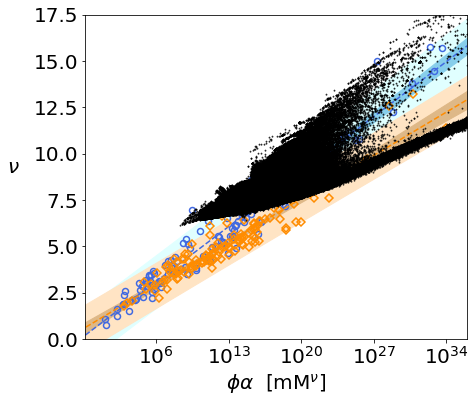

In [26]:
df = pd.read_csv('./mean_field_electrostatics/uniprot_hubbuch/clean.csv')

fig, ax = plot_lit_data()
ax.plot(df.phi_alpha, df.nu, '^', color='black', fillstyle='none', markersize=1)
# ax.legend(loc='upper left', handlelength=0.2, frameon=False)

fig.savefig(f'./images/mean_field_electrostatics/lit_data_vs_hubbuch.png', dpi=300, bbox_inches='tight')
fig.savefig(f'./images/mean_field_electrostatics/lit_data_vs_hubbuch.pdf', bbox_inches='tight')

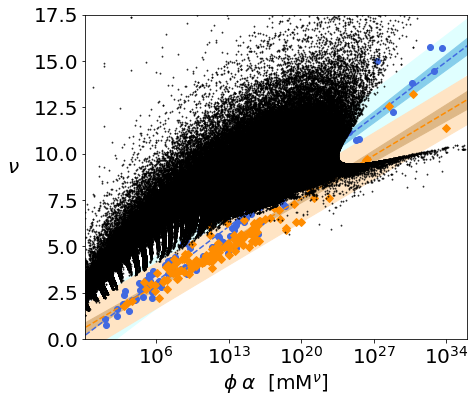

In [47]:
df = pd.read_csv('./mean_field_electrostatics/uniprot_morbidelli/clean.csv')

fig, ax = plot_lit_data()
ax.plot(df.phi_alpha, df.nu, '^', color='black', fillstyle='none', markersize=1)
# ax.legend(loc='upper left', handlelength=0.2, frameon=False)

fig.savefig(f'./images/mean_field_electrostatics/lit_data_vs_morbidelli.png', dpi=300)

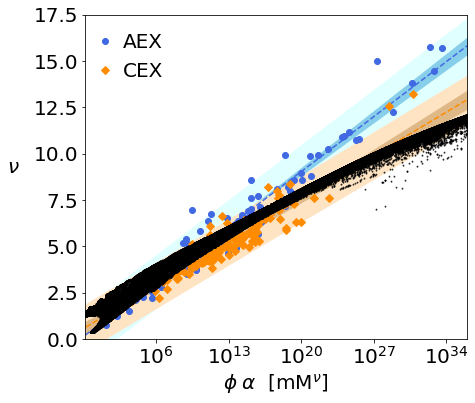

In [50]:
df = pd.read_csv('./mean_field_electrostatics/uniprot_morbidelli_positive_sign/clean.csv')

fig, ax = plot_lit_data()
ax.plot(df.phi_alpha, df.nu, '^', color='black', fillstyle='none', markersize=1)
ax.legend(loc='upper left', handlelength=0.2, frameon=False)

fig.savefig(f'./images/mean_field_electrostatics/lit_data_vs_morbidelli_positive_sign.png', dpi=300)